In [1]:
# Imports
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Hyperparams
# training config
NUM_EPOCHS= 200
LR=0.001
# dataset config
batch_size = 128
generator=torch.Generator().manual_seed(42) # Can be included for reproducability

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

NUM_CLASSES = 0

def getTrainingSet(dataset_name):
  NUM_CLASSES=10

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform_test)
    

  trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
  if dataset_name == 'CIFAR-10':
    NUM_CLASSES=10

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform_test)
    

    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
    
  elif dataset_name == 'STL10':
    NUM_CLASSES=10
    
    trainset = torchvision.datasets.STL10(root='./data', split='train',
                                          download=True, transform=transform_train)

    testset = torchvision.datasets.STL10(root='./data', split='test',
                                          download=True, transform=transform_train)
    

    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
    
  elif dataset_name == 'tiny-imagenet':
    NUM_CLASSES=200
    
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -qq 'tiny-imagenet-200.zip'
    
    
    totalset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', 
                                                   transform=transform_train)
  
    train_counts = [0] * 200
    valid_counts = [0] * 200
    trainset = []
    validset = []
    testset = []
    for item in totalset:
        if train_counts[item[1]] < 350:
            trainset.append(item)
            train_counts[item[1]] += 1
        elif valid_counts[item[1]] < 75:
            validset.append(item)
            valid_counts[item[1]] += 1
        else:
            testset.append(item)

  elif dataset_name == 'Caltech101':
    NUM_CLASSES=101
    !gdown https://drive.google.com/uc?id=1DX_XeKHn3yXtZ18DD7qc1wf-Jy5lnhD5
    !unzip -qq '101_ObjectCategories.zip' 

    PATH = '101_ObjectCategories/'

    transform = transforms.Compose(
      [transforms.CenterCrop(256),
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    totalset = torchvision.datasets.ImageFolder(PATH, transform=transform_train)

    X, y = zip(*totalset)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, 
                                                      stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                    test_size = 0.5, 
                                                    stratify=y_val)

    trainset, validset, testset = list(zip(X_train, y_train)), list(zip(X_val, y_val)), list(zip(X_test, y_test))




  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                            shuffle=False,num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainset, testset, trainloader, testloader

In [4]:
class VGGStyleNet(nn.Module):
    def __init__(self, num_classes: int = 10, init_weights: bool = True):
        super(VGGStyleNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        out = F.relu(self.conv1_1(x))
        out = F.relu(self.conv1_2(out))
        out = self.maxpool1(out)
        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.maxpool2(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [5]:
class ResNetBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [29]:
# Model


Files already downloaded and verified
Files already downloaded and verified


In [12]:
def train(max_lr, base_mommentum, dataset, mode , trainset, testset, trainloader, testloader):
  correct_images = 0
  total_images = 0
  training_loss = 0
  net = VGGStyleNet()
  net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  scheduler = None
  if (lr != "Baseline"):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=max_lr*0.25, max_lr=max_lr, mode=mode)
  validation_accuracy = []
  train_losses = []
  train_accuracies = []
  net.train()
  for epoch in range(20):
    training_loss = 0
    for batch_index, (images, labels) in enumerate(trainloader):
      optimizer.zero_grad()
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      if (lr != "Baseline"):
        optimizer.step()
        scheduler.step()
      else:
        optimizer.step()
      training_loss += loss.item()
      _, predicted = outputs.max(1)
      total_images += labels.size(0)
      correct_images += predicted.eq(labels).sum().item()
    print('Epoch: %d, Loss: %.3f, '
                'Accuracy: %.3f%% (%d/%d)' % (epoch, training_loss/(batch_index+1),
                                        100.*correct_images/total_images, correct_images, total_images))
    train_accuracies.append(100.*correct_images/total_images)
    correct_images = 0
    total_images = 0
    test_loss = 0
    net.eval()
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_images += labels.size(0)
        correct_images += predicted.eq(labels).sum().item()
#         print(batch_index, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                   % (test_loss/(batch_index+1), 100.*correct_images/total_images, correct_images, total_images))
    validation_accuracy.append(100.*correct_images/total_images)
    train_losses.append(training_loss)
  return net, train_losses, validation_accuracy, train_accuracies

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified




0it [00:00, ?it/s]

Epoch: 0, Loss: 1.846, Accuracy: 31.750% (12700/40000)
Epoch: 1, Loss: 1.399, Accuracy: 48.048% (24024/50000)
Epoch: 2, Loss: 1.159, Accuracy: 58.420% (29210/50000)
Epoch: 3, Loss: 0.997, Accuracy: 65.098% (32549/50000)
Epoch: 4, Loss: 0.881, Accuracy: 68.856% (34428/50000)
Epoch: 5, Loss: 0.799, Accuracy: 71.872% (35936/50000)
Epoch: 6, Loss: 0.736, Accuracy: 74.302% (37151/50000)
Epoch: 7, Loss: 0.679, Accuracy: 75.700% (37850/50000)
Epoch: 8, Loss: 0.629, Accuracy: 77.834% (38917/50000)
Epoch: 9, Loss: 0.591, Accuracy: 79.028% (39514/50000)
Epoch: 10, Loss: 0.554, Accuracy: 80.574% (40287/50000)
Epoch: 11, Loss: 0.536, Accuracy: 80.848% (40424/50000)
Epoch: 12, Loss: 0.500, Accuracy: 82.210% (41105/50000)
Epoch: 13, Loss: 0.471, Accuracy: 83.264% (41632/50000)
Epoch: 14, Loss: 0.442, Accuracy: 83.496% (41748/50000)
Epoch: 15, Loss: 0.424, Accuracy: 84.548% (42274/50000)
Epoch: 16, Loss: 0.402, Accuracy: 85.468% (42734/50000)
Epoch: 17, Loss: 0.385, Accuracy: 85.928% (42964/50000)
Ep



1it [07:01, 421.76s/it]

Epoch: 0, Loss: 1.775, Accuracy: 34.337% (13735/40000)


0it [08:10, ?it/s]
0it [08:10, ?it/s]
0it [08:11, ?it/s]
0it [08:11, ?it/s]
0it [08:13, ?it/s]


Epoch: 1, Loss: 1.287, Accuracy: 52.796% (26398/50000)
Epoch: 2, Loss: 1.032, Accuracy: 63.278% (31639/50000)
Epoch: 3, Loss: 0.899, Accuracy: 68.928% (34464/50000)
Epoch: 4, Loss: 0.808, Accuracy: 71.648% (35824/50000)
Epoch: 5, Loss: 0.754, Accuracy: 73.496% (36748/50000)
Epoch: 6, Loss: 0.694, Accuracy: 76.434% (38217/50000)
Epoch: 7, Loss: 0.643, Accuracy: 77.146% (38573/50000)
Epoch: 8, Loss: 0.581, Accuracy: 79.376% (39688/50000)
Epoch: 9, Loss: 0.541, Accuracy: 80.950% (40475/50000)
Epoch: 10, Loss: 0.497, Accuracy: 82.706% (41353/50000)
Epoch: 11, Loss: 0.444, Accuracy: 84.394% (42197/50000)
Epoch: 12, Loss: 0.396, Accuracy: 85.650% (42825/50000)
Epoch: 13, Loss: 0.389, Accuracy: 85.860% (42930/50000)
Epoch: 14, Loss: 0.409, Accuracy: 85.588% (42794/50000)
Epoch: 15, Loss: 0.422, Accuracy: 84.734% (42367/50000)
Epoch: 16, Loss: 0.436, Accuracy: 84.408% (42204/50000)
Epoch: 17, Loss: 0.438, Accuracy: 84.332% (42166/50000)
Epoch: 18, Loss: 0.439, Accuracy: 84.466% (42233/50000)
E



2it [13:57, 418.48s/it]

Epoch: 0, Loss: 2.013, Accuracy: 26.045% (10418/40000)
Epoch: 1, Loss: 1.587, Accuracy: 41.758% (20879/50000)
Epoch: 2, Loss: 1.414, Accuracy: 48.126% (24063/50000)
Epoch: 3, Loss: 1.294, Accuracy: 53.790% (26895/50000)
Epoch: 4, Loss: 1.180, Accuracy: 57.646% (28823/50000)
Epoch: 5, Loss: 1.073, Accuracy: 62.276% (31138/50000)
Epoch: 6, Loss: 0.979, Accuracy: 65.772% (32886/50000)
Epoch: 7, Loss: 0.898, Accuracy: 68.504% (34252/50000)
Epoch: 8, Loss: 0.825, Accuracy: 71.284% (35642/50000)
Epoch: 9, Loss: 0.771, Accuracy: 72.992% (36496/50000)
Epoch: 10, Loss: 0.715, Accuracy: 74.456% (37228/50000)
Epoch: 11, Loss: 0.675, Accuracy: 76.326% (38163/50000)
Epoch: 12, Loss: 0.625, Accuracy: 77.960% (38980/50000)
Epoch: 13, Loss: 0.610, Accuracy: 78.754% (39377/50000)
Epoch: 14, Loss: 0.602, Accuracy: 78.912% (39456/50000)
Epoch: 15, Loss: 0.588, Accuracy: 78.938% (39469/50000)
Epoch: 16, Loss: 0.572, Accuracy: 79.554% (39777/50000)
Epoch: 17, Loss: 0.553, Accuracy: 80.490% (40245/50000)
Ep



3it [21:08, 423.98s/it]

Epoch: 0, Loss: 2.283, Accuracy: 13.305% (5322/40000)
Epoch: 1, Loss: 2.126, Accuracy: 24.226% (12113/50000)
Epoch: 2, Loss: 1.954, Accuracy: 29.682% (14841/50000)
Epoch: 3, Loss: 1.835, Accuracy: 34.264% (17132/50000)
Epoch: 4, Loss: 1.726, Accuracy: 38.250% (19125/50000)
Epoch: 5, Loss: 1.631, Accuracy: 41.106% (20553/50000)
Epoch: 6, Loss: 1.554, Accuracy: 44.068% (22034/50000)
Epoch: 7, Loss: 1.501, Accuracy: 45.830% (22915/50000)
Epoch: 8, Loss: 1.458, Accuracy: 47.534% (23767/50000)
Epoch: 9, Loss: 1.416, Accuracy: 49.348% (24674/50000)
Epoch: 10, Loss: 1.396, Accuracy: 50.142% (25071/50000)
Epoch: 11, Loss: 1.362, Accuracy: 51.512% (25756/50000)
Epoch: 12, Loss: 1.337, Accuracy: 52.216% (26108/50000)
Epoch: 13, Loss: 1.326, Accuracy: 52.618% (26309/50000)
Epoch: 14, Loss: 1.317, Accuracy: 53.040% (26520/50000)
Epoch: 15, Loss: 1.297, Accuracy: 53.864% (26932/50000)
Epoch: 16, Loss: 1.279, Accuracy: 54.704% (27352/50000)
Epoch: 17, Loss: 1.261, Accuracy: 55.624% (27812/50000)
Epo



4it [28:21, 427.42s/it]

DONESKDAKSDJLSD


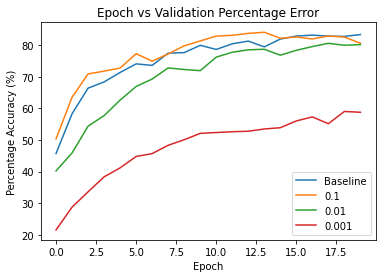

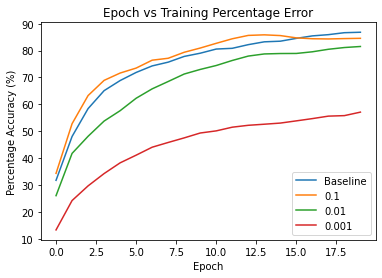

0it [36:31, ?it/s]


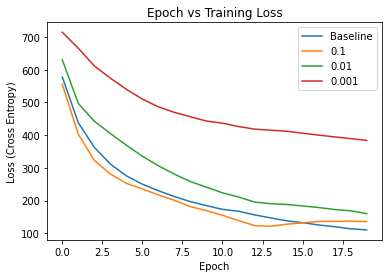

Epoch: 0, Loss: 1.846, Accuracy: 31.648% (12659/40000)
Epoch: 1, Loss: 1.401, Accuracy: 48.434% (24217/50000)
Epoch: 2, Loss: 1.167, Accuracy: 57.798% (28899/50000)
Epoch: 3, Loss: 0.998, Accuracy: 64.824% (32412/50000)
Epoch: 4, Loss: 0.875, Accuracy: 69.088% (34544/50000)
Epoch: 5, Loss: 0.787, Accuracy: 72.432% (36216/50000)
Epoch: 6, Loss: 0.724, Accuracy: 74.642% (37321/50000)
Epoch: 7, Loss: 0.674, Accuracy: 76.444% (38222/50000)
Epoch: 8, Loss: 0.632, Accuracy: 77.450% (38725/50000)
Epoch: 9, Loss: 0.591, Accuracy: 79.214% (39607/50000)
Epoch: 10, Loss: 0.559, Accuracy: 80.296% (40148/50000)
Epoch: 11, Loss: 0.521, Accuracy: 81.696% (40848/50000)
Epoch: 12, Loss: 0.500, Accuracy: 82.446% (41223/50000)
Epoch: 13, Loss: 0.470, Accuracy: 83.130% (41565/50000)
Epoch: 14, Loss: 0.447, Accuracy: 83.848% (41924/50000)
Epoch: 15, Loss: 0.424, Accuracy: 84.662% (42331/50000)
Epoch: 16, Loss: 0.405, Accuracy: 85.142% (42571/50000)
Epoch: 17, Loss: 0.386, Accuracy: 85.808% (42904/50000)
Ep



5it [35:27, 427.13s/it]

Epoch: 0, Loss: 1.773, Accuracy: 34.633% (13853/40000)
Epoch: 1, Loss: 1.288, Accuracy: 52.266% (26133/50000)


In [ ]:
import matplotlib.pyplot as plt

cycleLRModes = ['triangular', 'triangular2', 'exp_range']
learning_rates = ["Baseline", 0.1, 0.01, 0.001]
datasets = ["CIFAR-10", "Caltech101", "STL10"]
datasets = ["CIFAR-10"]

for data in datasets:
  trainset, testset, trainloader, testloader = getTrainingSet(data)
  t = tqdm(len(cycleLRModes) * len(learning_rates))
  for mode in cycleLRModes:
    validation_curves = {}
    train_curves = {}
    train_loss_curves = {}
    for lr in learning_rates:
      net, train_losses, validation_accuracy, train_accuracies = train(lr, 0.8,data, mode, trainset, testset, trainloader, testloader)
      validation_curves[lr] = validation_accuracy
      train_curves[lr] = train_accuracies
      train_loss_curves[lr] = train_losses
      t.update(1)

    print("DONESKDAKSDJLSD")

    for l in validation_curves:
      plt.plot(validation_curves[l], label = l)
    plt.title("Epoch vs Validation Percentage Error")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage Accuracy (%)")
    plt.legend()
    plt.show()

    for l in train_curves:
      plt.plot(train_curves[l], label = l)
    plt.title("Epoch vs Training Percentage Error")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage Accuracy (%)")
    plt.legend()
    plt.show()

    for l in train_loss_curves:
      plt.plot(train_loss_curves[l], label = l)
    plt.title("Epoch vs Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Cross Entropy)")
    plt.legend()
    plt.show()